In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv', index_col=[0])
df

,positive,negative,neutral,none,count,known,to_predict
Date,,,,,,,
2018-01-03,22,11,1,0,34,0.37,-0.190000
2018-01-04,24,8,4,0,36,-0.19,-0.040000
2018-01-05,21,5,2,0,28,-0.04,0.010000
2018-01-08,24,1,1,0,26,0.01,-0.140000
2018-01-09,25,8,5,0,38,-0.14,-0.140000
...,...,...,...,...,...,...,...
2018-05-24,14,5,3,0,22,-0.17,-0.040000
2018-05-25,14,3,1,0,18,-0.04,0.120000
2018-05-29,20,5,2,0,27,0.12,0.010000


In [191]:
def get_absa_df():
    absa_df = pd.read_csv('./data/processed_absa_price_diff.csv')

#     absa_df = absa_df.drop(columns=['Date'])
#     print(absa_df.columns[:-3])
    for col in absa_df.columns[:-3]:
        if col == 'Date':
            continue
        absa_df[col] /= absa_df['count']
    absa_df = absa_df.drop(columns=['count'])
    
    return absa_df

In [195]:
np.sum(get_absa_df()['design features_neutral']>0)

2

In [163]:
def get_absa_no_known_df():
    absa_df = pd.read_csv('./data/processed_absa_price_diff.csv')

#     absa_df = absa_df.drop(columns=['Date'])
    print(absa_df.columns[:-3])
    for col in absa_df.columns[:-3]:
        if col == 'Date':
            continue
        absa_df[col] /= absa_df['count']
    absa_df = absa_df.drop(columns=['count','known'])
    
    return absa_df

In [160]:
def pure_stock_df():
    df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')
    df = df[['Date','known','to_predict']]
    return df

In [161]:
pure_stock_df()

,Date,known,to_predict
0,2018-01-03,0.37,-0.190000
1,2018-01-04,-0.19,-0.040000
2,2018-01-05,-0.04,0.010000
3,2018-01-08,0.01,-0.140000
4,2018-01-09,-0.14,-0.140000
...,...,...,...
98,2018-05-24,-0.17,-0.040000
99,2018-05-25,-0.04,0.120000
100,2018-05-29,0.12,0.010000
101,2018-05-30,0.01,-0.120000


# generalized linear model

## pure stock price

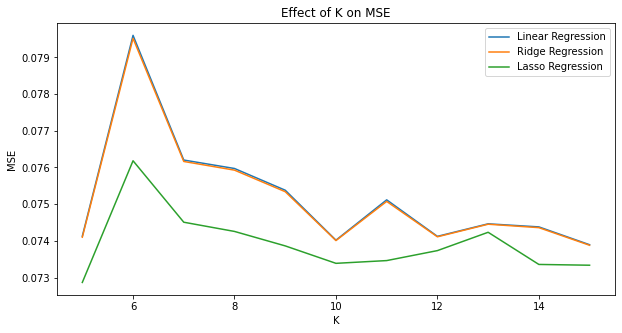

Linear Regression: 0.0739
Ridge Regression: 0.0739
Lasso Regression: 0.0729


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Load the data
df = pure_stock_df()

# Split the data into predictor variables and target variable
X = df.drop(['to_predict', 'Date'], axis=1).values
y = df['to_predict'].values

# Normalize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
]

# Define the range of K values
k_values = range(5, 16)

# Define a dictionary to store the MSE values for each model and each K value
mse_dict = {model_name: {k: [] for k in k_values} for model_name, _ in models}

# Loop through the K values and perform K-fold cross-validation
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Loop through the models and fit them on the training data
        for model_name, model in models:
            model.fit(X_train, y_train)
            
            # Predict on the test data and calculate the MSE
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            # Store the MSE in the dictionary
            mse_dict[model_name][k].append(mse)

# Plot the effect of different K values on the MSE
plt.figure(figsize=(10, 5))
for model_name, _ in models:
    mse_values = [np.mean(mse_dict[model_name][k]) for k in k_values]
    plt.plot(k_values, mse_values, label=model_name)
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('Effect of K on MSE')
plt.legend()
plt.show()

best_mse = {}
for model_name, _ in models:
    best_mse[model_name] = np.min([np.mean(mse_dict[model_name][k]) for k in k_values])
    print(f'{model_name}: {best_mse[model_name]:.4f}')



Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.05857020818056

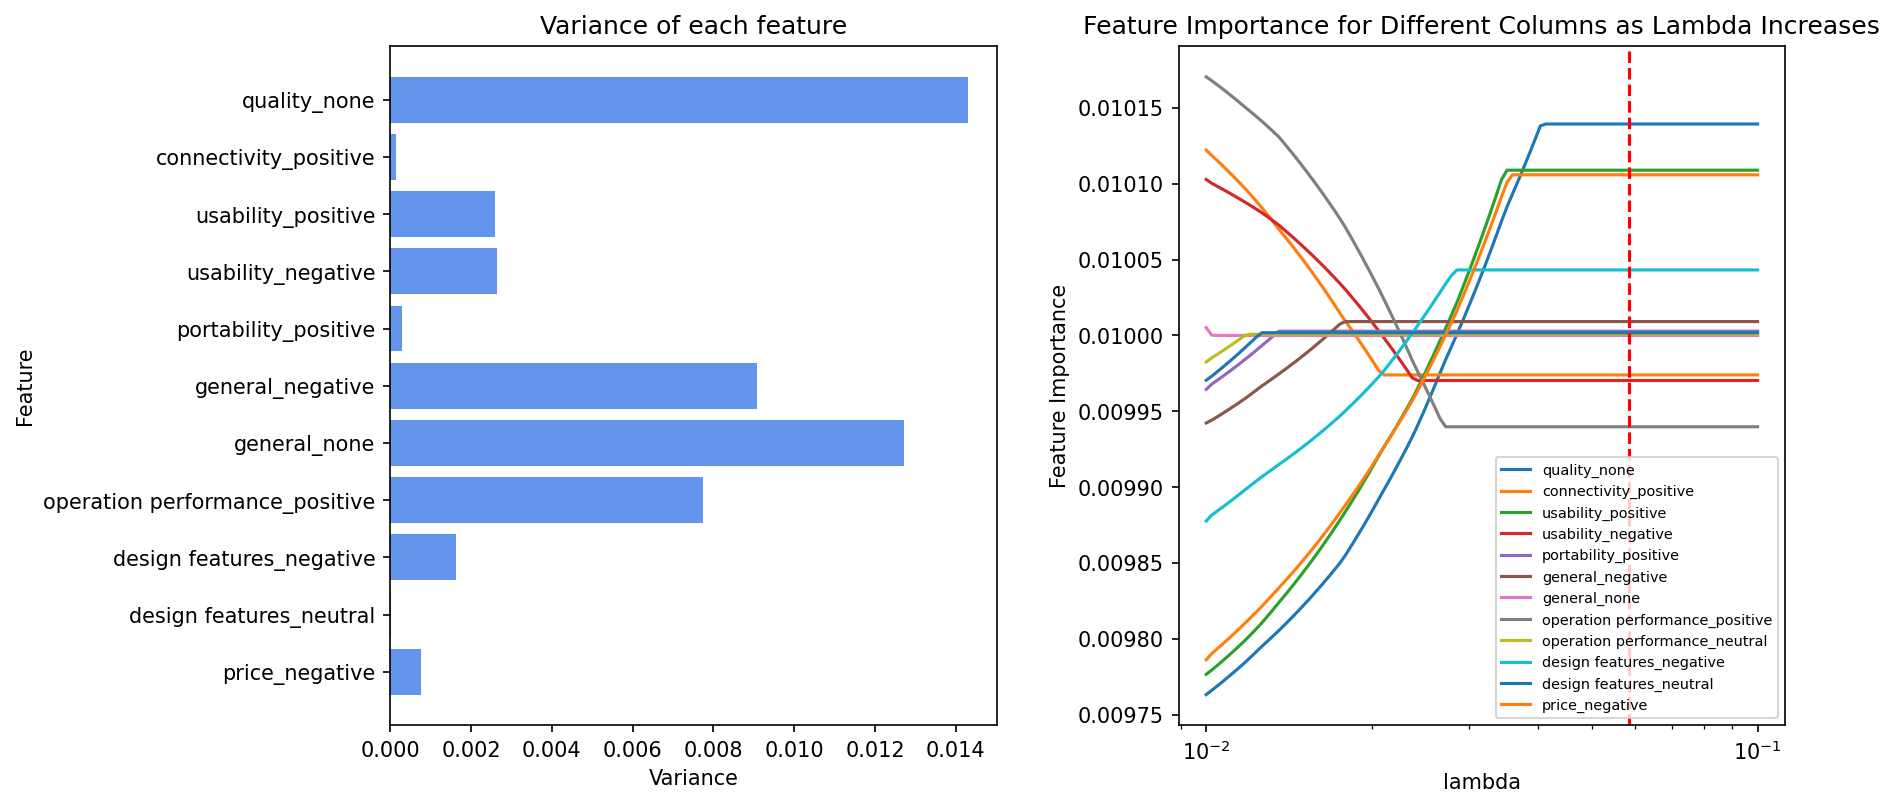

{'lasso__alpha': 0.05857020818056667}


In [187]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

# Load data
df = get_absa_no_known_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Define the Lasso model
model = make_pipeline(StandardScaler(), Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, -1, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]

# Plot variance of selected features
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Define feature order for barplot
feature_order = ['quality_none', 'connectivity_positive', 'usability_positive',
                 'usability_negative', 'portability_positive', 'general_negative',
                 'general_none', 'operation performance_positive', 'design features_negative',
                 'design features_neutral', 'price_negative']

# Calculate the variance of each column and select relevant columns
variances = df[feature_order].var()

# Plot bar chart of variances
axs[0].barh(y=variances.index, width=variances.values, color='cornflowerblue')
axs[0].set_title('Variance of each feature')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Feature')
axs[0].invert_yaxis()

# Plot feature importance for different columns as lambda increases
for feature in X.columns:
    feature_importance = []
    for param in params:
        model.set_params(**param)
        model.fit(X, y)
        coef = model.named_steps['lasso'].coef_
        feature_importance.append((coef[X.columns == feature]))
    feature_importance = np.array(feature_importance).flatten()
    if np.sum(np.abs(feature_importance)) > 0:
        if np.max(feature_importance) == np.min(feature_importance):
            feature_importance = np.ones_like(feature_importance) / len(feature_importance)
        else:
            feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
#         color = axs[0].get_children()[::-1][feature_order.index(feature)].get_facecolor()
        axs[1].semilogx(alphas, feature_importance, label=feature)
best_alpha = grid.best_params_['lasso__alpha']
axs[1].axvline(best_alpha, color='r', linestyle='--')
axs[1].set_xlabel('lambda')
axs[1].set_ylabel('Feature Importance')
axs[1].set_title('Feature Importance for Different Columns as Lambda Increases')
axs[1].legend(loc='lower right', fontsize='x-small')
plt.subplots_adjust(wspace=0.3)
plt.show()
print(grid.best_params_)

In [188]:
# Define a Lasso model with your own alpha value
lasso = Lasso(alpha=0.05857020818056667)

# Fit the Lasso model on the standardized predictors and target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso.fit(X_scaled, y)

# Print the coefficients of the features
coef = lasso.coef_
non_zero_features = X.columns[coef != 0]
coef = coef[coef != 0]
sorted_coef_idx = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_coef_idx]
sorted_features = non_zero_features[sorted_coef_idx]
print('Non-zero coefficients:')
for feature, c in zip(sorted_features, sorted_coef):
    print(f'{feature}: {c:.3f}')


Non-zero coefficients:


Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.01}
MSE: 0.079

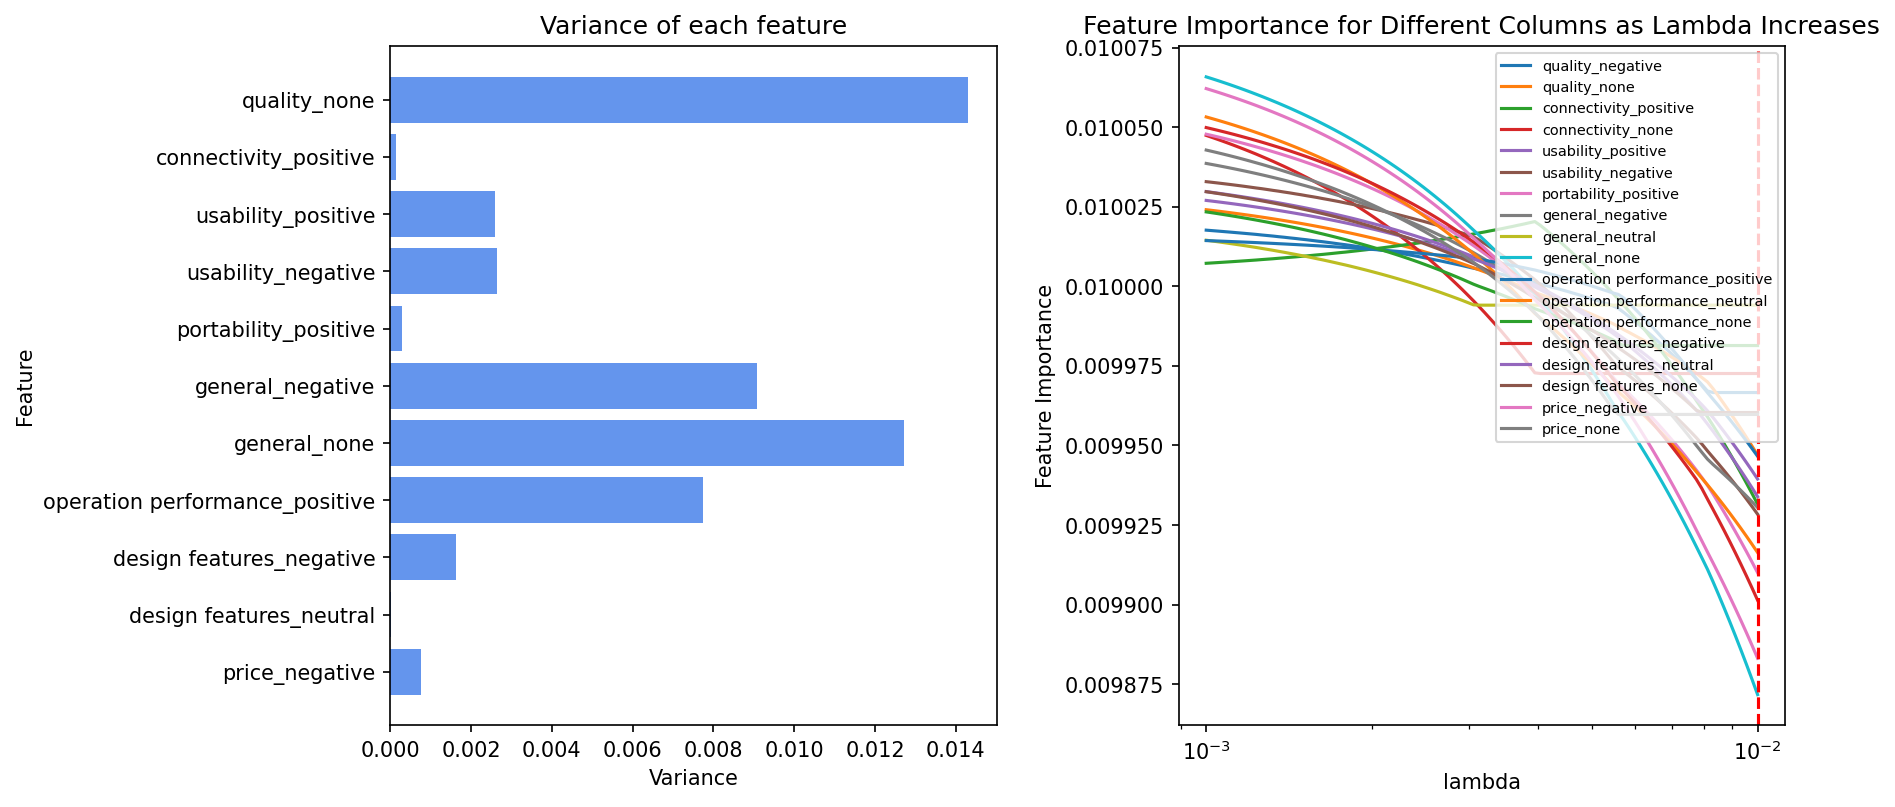

In [170]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

# Load data
df = get_absa_no_known_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Define the Lasso model
model = make_pipeline(StandardScaler(), Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-3, -2, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]

# Plot variance of selected features
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Define feature order for barplot
feature_order = ['quality_none', 'connectivity_positive', 'usability_positive',
                 'usability_negative', 'portability_positive', 'general_negative',
                 'general_none', 'operation performance_positive', 'design features_negative',
                 'design features_neutral', 'price_negative']

# Calculate the variance of each column and select relevant columns
variances = df[feature_order].var()

# Plot bar chart of variances
axs[0].barh(y=variances.index, width=variances.values, color='cornflowerblue')
axs[0].set_title('Variance of each feature')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Feature')
axs[0].invert_yaxis()

# Plot feature importance for different columns as lambda increases
for feature in X.columns:
    feature_importance = []
    for param in params:
        model.set_params(**param)
        model.fit(X, y)
        coef = model.named_steps['lasso'].coef_
        feature_importance.append(np.abs(coef[X.columns == feature]))
    feature_importance = np.array(feature_importance).flatten()
    if np.sum(np.abs(feature_importance)) > 0:
        if np.max(feature_importance) == np.min(feature_importance):
            feature_importance = np.ones_like(feature_importance) / len(feature_importance)
        else:
            feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
#         color = axs[0].get_children()[::-1][feature_order.index(feature)].get_facecolor()
        axs[1].semilogx(alphas, feature_importance, label=feature)
best_alpha = grid.best_params_['lasso__alpha']
axs[1].axvline(best_alpha, color='r', linestyle='--')
axs[1].set_xlabel('lambda')
axs[1].set_ylabel('Feature Importance')
axs[1].set_title('Feature Importance for Different Columns as Lambda Increases')
axs[1].legend(loc='upper right', fontsize='x-small')
plt.subplots_adjust(wspace=0.3)
plt.show()


## bert-base-sa: compare OLS, Ridge, LASSO

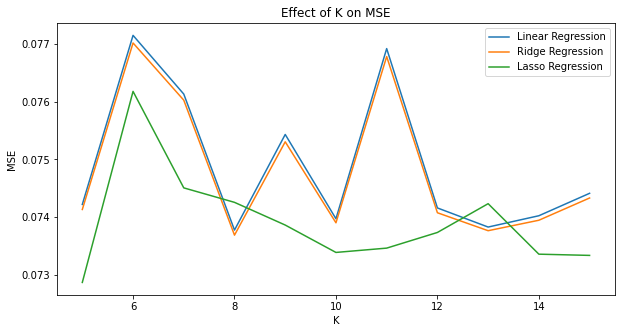

Linear Regression: 0.0738
Ridge Regression: 0.0737
Lasso Regression: 0.0729


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Load the data
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')

# Split the data into predictor variables and target variable
X = df.drop(['to_predict', 'Date'], axis=1).values
y = df['to_predict'].values

# Normalize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
]

# Define the range of K values
k_values = range(5, 16)

# Define a dictionary to store the MSE values for each model and each K value
mse_dict = {model_name: {k: [] for k in k_values} for model_name, _ in models}

# Loop through the K values and perform K-fold cross-validation
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Loop through the models and fit them on the training data
        for model_name, model in models:
            model.fit(X_train, y_train)
            
            # Predict on the test data and calculate the MSE
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            # Store the MSE in the dictionary
            mse_dict[model_name][k].append(mse)

# Plot the effect of different K values on the MSE
plt.figure(figsize=(10, 5))
for model_name, _ in models:
    mse_values = [np.mean(mse_dict[model_name][k]) for k in k_values]
    plt.plot(k_values, mse_values, label=model_name)
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('Effect of K on MSE')
plt.legend()
plt.show()

best_mse = {}
for model_name, _ in models:
    best_mse[model_name] = np.min([np.mean(mse_dict[model_name][k]) for k in k_values])
    print(f'{model_name}: {best_mse[model_name]:.4f}')



## absa: compare OLS, Ridge, LASSO

Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')


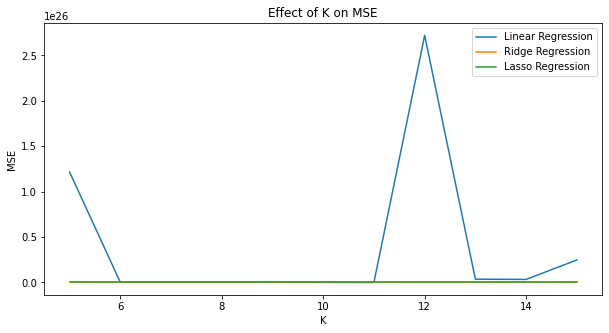

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Load the data
df = get_absa_df()

# Split the data into predictor variables and target variable
X = df.drop(['to_predict', 'Date'], axis=1).values
y = df['to_predict'].values

# Normalize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
]

# Define the range of K values
k_values = range(5, 16)

# Define a dictionary to store the MSE values for each model and each K value
mse_dict = {model_name: {k: [] for k in k_values} for model_name, _ in models}

# Loop through the K values and perform K-fold cross-validation
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Loop through the models and fit them on the training data
        for model_name, model in models:
            model.fit(X_train, y_train)
            
            # Predict on the test data and calculate the MSE
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            # Store the MSE in the dictionary
            mse_dict[model_name][k].append(mse)

# Plot the effect of different K values on the MSE
plt.figure(figsize=(10, 5))
for model_name, _ in models:
    mse_values = [np.mean(mse_dict[model_name][k]) for k in k_values]
    plt.plot(k_values, mse_values, label=model_name)
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('Effect of K on MSE')
plt.legend()
plt.show()


## USE ElasticNet and Hyperparameter Tuning for penalization

$$\min _w \frac{1}{2 n_{\text {samples }}}\|X w-y\|_2^2+\alpha \rho\|w\|_1+\frac{\alpha(1-\rho)}{2}\|w\|_2^2$$

$\alpha$: alpha

$\rho$: l1-ratio

In [2]:
import pandas as pd
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')
df

,Date,positive,negative,neutral,none,count,known,to_predict
0,2018-01-03,22,11,1,0,34,0.37,-0.190000
1,2018-01-04,24,8,4,0,36,-0.19,-0.040000
2,2018-01-05,21,5,2,0,28,-0.04,0.010000
3,2018-01-08,24,1,1,0,26,0.01,-0.140000
4,2018-01-09,25,8,5,0,38,-0.14,-0.140000
...,...,...,...,...,...,...,...,...
98,2018-05-24,14,5,3,0,22,-0.17,-0.040000
99,2018-05-25,14,3,1,0,18,-0.04,0.120000
100,2018-05-29,20,5,2,0,27,0.12,0.010000
101,2018-05-30,24,4,1,0,29,0.01,-0.120000


Best hyperparameters: {'elasticnet__alpha': 0.07054802310718646}
MSE: 0.0730696443893987


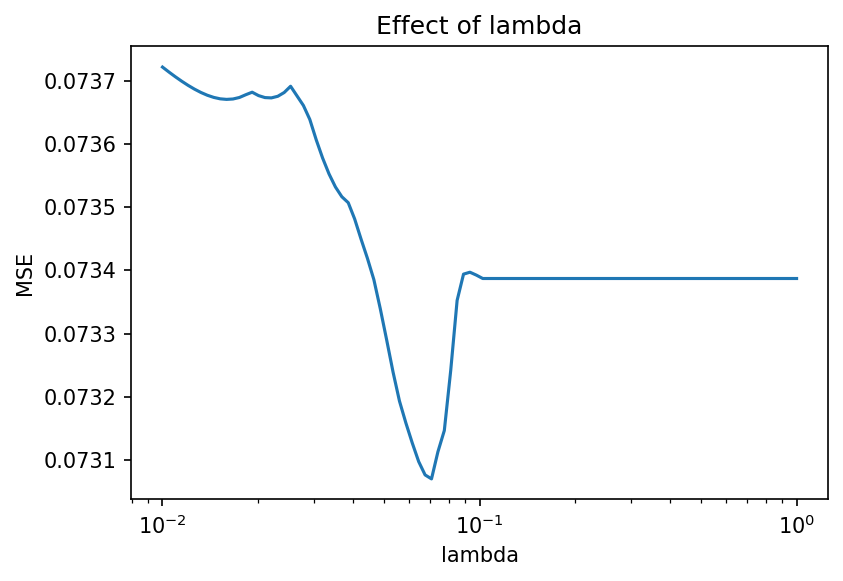

In [99]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Normalize the predictor variables
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Define the ElasticNet model
model = make_pipeline(ElasticNet())

# Define the grid of hyperparameters to search over
param_grid = {
    'elasticnet__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X_norm, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['elasticnet__alpha'] for param in params]
plt.figure(dpi=150)
plt.semilogx(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('Effect of lambda')
plt.show()


## Directly use LASSO on the absa price difference prediction

Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.06135907273413

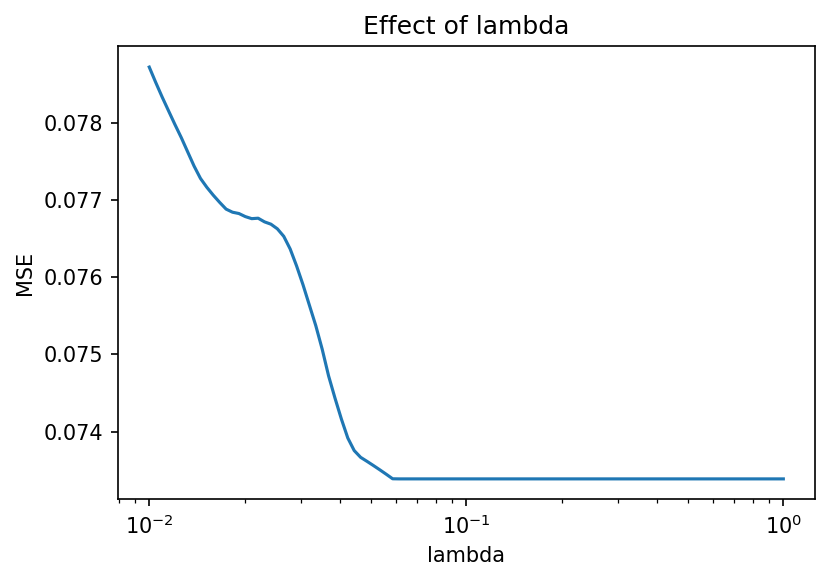

Non-zero coefficients:


In [106]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = get_absa_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Normalize the predictor variables
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Define the Lasso model
model = make_pipeline(Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X_norm, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]
plt.figure(dpi=150)
plt.semilogx(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('Effect of lambda')
plt.show()

# Print the non-zero coefficients and corresponding features in decreasing order of absolute value
coef = grid.best_estimator_.named_steps['lasso'].coef_
non_zero_features = X.columns[coef != 0]
coef = coef[coef != 0]
sorted_coef_idx = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_coef_idx]
sorted_features = non_zero_features[sorted_coef_idx]
print('Non-zero coefficients:')
for feature, c in zip(sorted_features, sorted_coef):
    print(f'{feature}: {c:.3f}')


Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.06135907273413

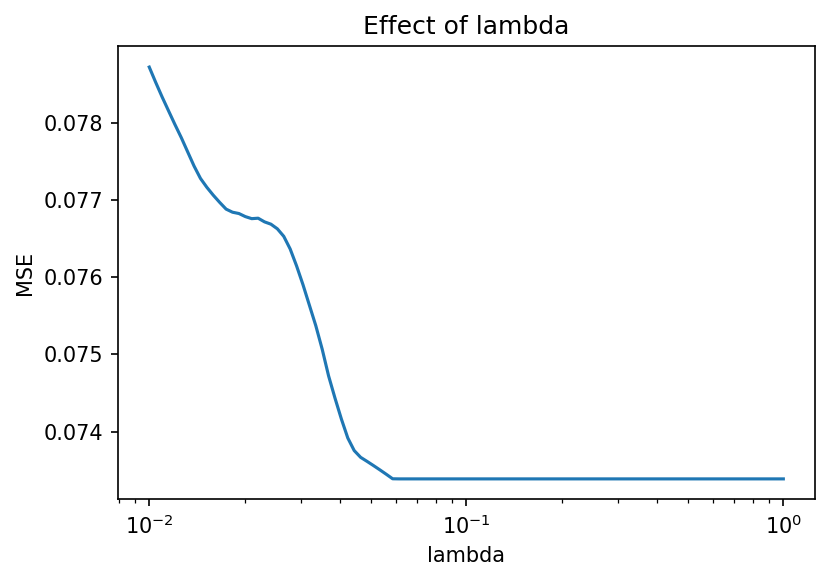

Non-zero coefficients:


In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = get_absa_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Normalize the predictor variables
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Define the Lasso model
model = make_pipeline(Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X_norm, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]
plt.figure(dpi=150)
plt.semilogx(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('Effect of lambda')
plt.show()

# Print the non-zero coefficients and corresponding features in decreasing order of absolute value
coef = grid.best_estimator_.named_steps['lasso'].coef_
non_zero_features = X.columns[coef != 0]
coef = coef[coef != 0]
sorted_coef_idx = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_coef_idx]
sorted_features = non_zero_features[sorted_coef_idx]
print('Non-zero coefficients:')
for feature, c in zip(sorted_features, sorted_coef):
    print(f'{feature}: {c:.3f}')

# # Create a new figure to visualize feature importance for different columns as lambda increases
# plt.figure(dpi=150)
# for feature in X.columns:
#     feature_importance = []
#     for param in params:
#         model.set_params(**param)
#         model.fit(X_norm, y)
#         coef = model.named_steps['lasso'].coef_
#         feature_importance.append(np.abs(coef[X.columns==feature])) # modify here!
#     feature_importance = np.array(feature_importance).flatten()
#     if np.sum(np.abs(feature_importance)) > 0:
#         if np.max(feature_importance) == np.min(feature_importance):
#             feature_importance = np.ones_like(feature_importance) / len(feature_importance)
#         else:
#             feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
#         plt.semilogx(alphas, feature_importance, label=feature)
# plt.xlabel('lambda')
# plt.ylabel('Feature Importance')
# plt.title('Feature Importance for Different Columns as Lambda Increases')
# plt.legend(loc='upper right', fontsize='x-small')
# plt.show()


In [183]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ipywidgets import interact

# Load data
df = get_absa_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Normalize the predictor variables
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Define the Lasso model
model = make_pipeline(Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X_norm, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]

# Define a function to plot the feature importance for different columns as lambda increases
def plot_feature_importance(lambda_val):
    model.set_params(lasso__alpha=lambda_val)
    model.fit(X_norm, y)
    coef = model.named_steps['lasso'].coef_
    feature_importance = np.exp(np.abs(coef)) / np.sum(np.exp(np.abs(coef)))
    sorted_idx = np.argsort(feature_importance)[::-1]
    sorted_features = X.columns[sorted_idx]
    sorted_importance = feature_importance[sorted_idx]
    plt.figure(dpi=150, figsize=(10,6))
    plt.barh(sorted_features, sorted_importance)
    plt.title(f'Feature Importance for lambda={lambda_val:.3f}')
    plt.xlabel('Feature Importance')
#     plt.xlim(0, 0.1)
    plt.tight_layout()
    plt.show()

# Use interact to create a slider for lambda_val and plot the feature importance
lambda_val = (0.0001, 0.1, 0.001)
interact(plot_feature_importance, lambda_val=lambda_val);


Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.06135907273413

interactive(children=(FloatSlider(value=0.049100000000000005, description='lambda_val', max=0.1, min=0.0001, s…

Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.06135907273413

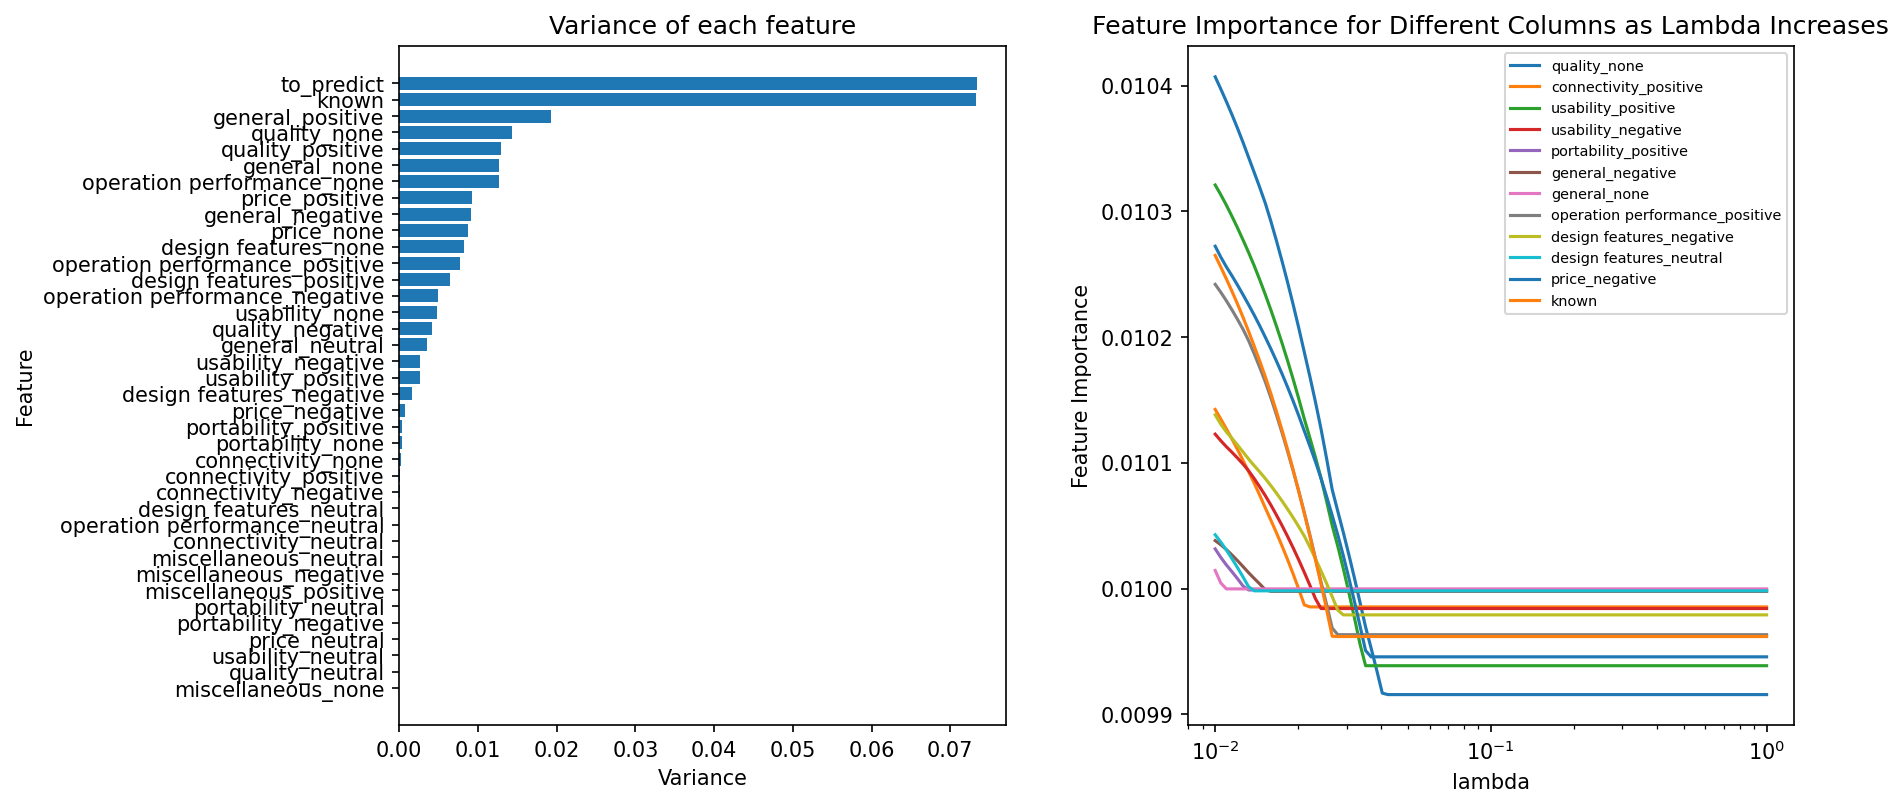

In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = get_absa_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Normalize the predictor variables
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Define the Lasso model
model = make_pipeline(Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X_norm, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Plot variance of each feature
df = get_absa_df()
variances = df.drop('Date', axis=1).var()
variances_sorted = variances.sort_values(ascending=False)
axs[0].barh(y=variances_sorted.index, width=variances_sorted.values)
axs[0].set_title('Variance of each feature')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Feature')
axs[0].invert_yaxis()

# Plot feature importance for different columns as lambda increases
for feature in X.columns:
    feature_importance = []
    for param in params:
        model.set_params(**param)
        model.fit(X_norm, y)
        coef = model.named_steps['lasso'].coef_
        feature_importance.append(np.abs(coef[X.columns==feature]))
    feature_importance = np.array(feature_importance).flatten()
    if np.sum(np.abs(feature_importance)) > 0:
        if np.max(feature_importance) == np.min(feature_importance):
            feature_importance = np.ones_like(feature_importance) / len(feature_importance)
        else:
            feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
        axs[1].semilogx(alphas, feature_importance, label=feature)

axs[1].set_xlabel('lambda')
axs[1].set_ylabel('Feature Importance')
axs[1].set_title('Feature Importance for Different Columns as Lambda Increases')
axs[1].legend(loc='upper right', fontsize='x-small')
plt.subplots_adjust(wspace=0.3)
plt.show()


Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.05857020818056

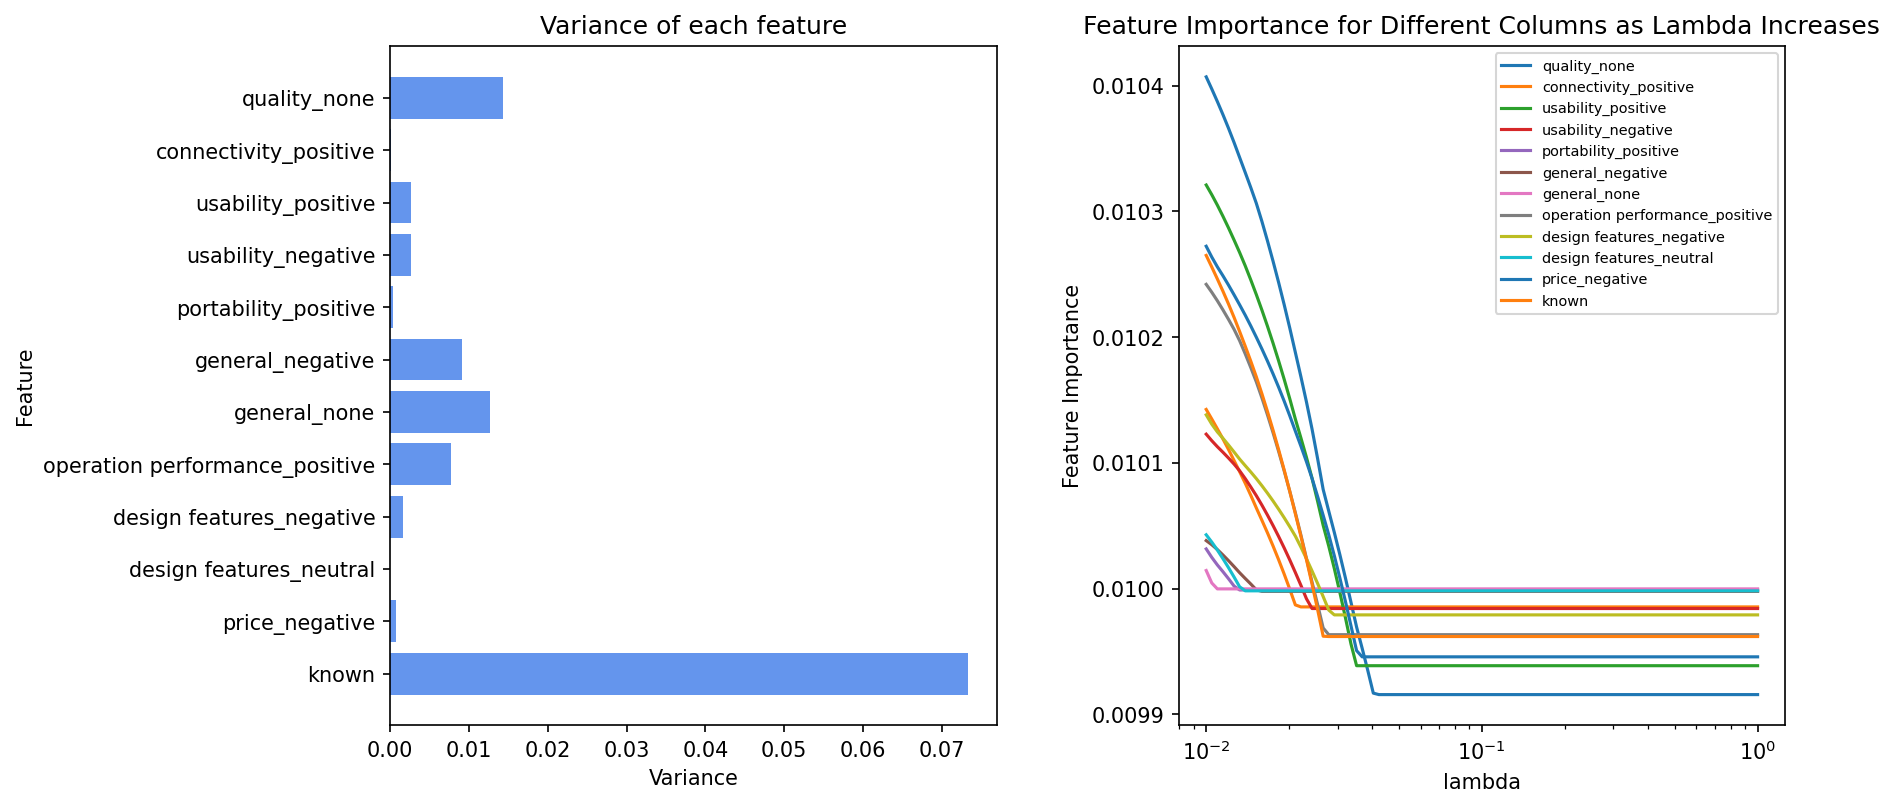

In [141]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

# Load data
df = get_absa_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Define the Lasso model
model = make_pipeline(StandardScaler(), Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]

# Plot variance of selected features
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Define feature order for barplot
feature_order = ['quality_none', 'connectivity_positive', 'usability_positive',
                 'usability_negative', 'portability_positive', 'general_negative',
                 'general_none', 'operation performance_positive', 'design features_negative',
                 'design features_neutral', 'price_negative', 'known']

# Calculate the variance of each column and select relevant columns
variances = df[feature_order].var()

# Plot bar chart of variances
axs[0].barh(y=variances.index, width=variances.values, color='cornflowerblue')
axs[0].set_title('Variance of each feature')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Feature')
axs[0].invert_yaxis()

# Plot feature importance for different columns as lambda increases
for feature in X.columns:
    feature_importance = []
    for param in params:
        model.set_params(**param)
        model.fit(X, y)
        coef = model.named_steps['lasso'].coef_
        feature_importance.append(np.abs(coef[X.columns == feature]))
    feature_importance = np.array(feature_importance).flatten()
    if np.sum(np.abs(feature_importance)) > 0:
        if np.max(feature_importance) == np.min(feature_importance):
            feature_importance = np.ones_like(feature_importance) / len(feature_importance)
        else:
            feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
#         color = axs[0].get_children()[::-1][feature_order.index(feature)].get_facecolor()
        axs[1].semilogx(alphas, feature_importance, label=feature)

axs[1].set_xlabel('lambda')
axs[1].set_ylabel('Feature Importance')
axs[1].set_title('Feature Importance for Different Columns as Lambda Increases')
axs[1].legend(loc='upper right', fontsize='x-small')
plt.subplots_adjust(wspace=0.3)
plt.show()


Index(['Date', 'quality_positive', 'quality_negative', 'quality_neutral',
       'quality_none', 'connectivity_positive', 'connectivity_negative',
       'connectivity_neutral', 'connectivity_none', 'usability_positive',
       'usability_negative', 'usability_neutral', 'usability_none',
       'portability_positive', 'portability_negative', 'portability_neutral',
       'portability_none', 'miscellaneous_positive', 'miscellaneous_negative',
       'miscellaneous_neutral', 'miscellaneous_none', 'general_positive',
       'general_negative', 'general_neutral', 'general_none',
       'operation performance_positive', 'operation performance_negative',
       'operation performance_neutral', 'operation performance_none',
       'design features_positive', 'design features_negative',
       'design features_neutral', 'design features_none', 'price_positive',
       'price_negative', 'price_neutral', 'price_none'],
      dtype='object')
Best hyperparameters: {'lasso__alpha': 0.05857020818056

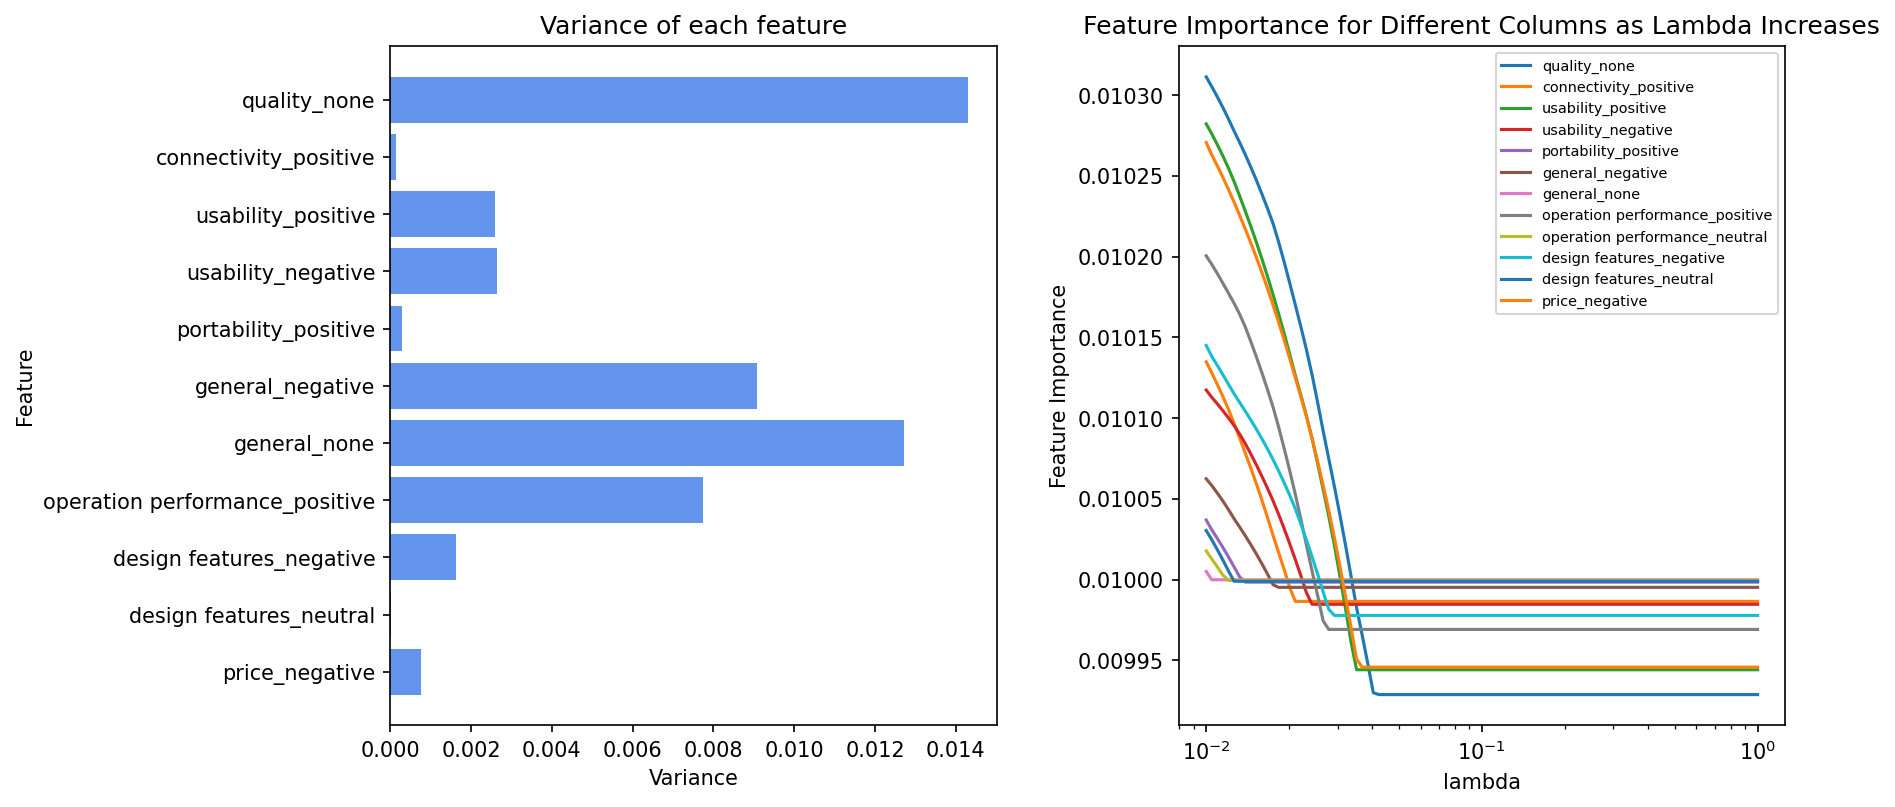

In [166]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

# Load data
df = get_absa_no_known_df()
df = df.drop(columns=['Date'])

# Split data into predictors (X) and target (y)
X = df.drop(['to_predict'], axis=1)
y = df['to_predict']

# Define the Lasso model
model = make_pipeline(StandardScaler(), Lasso())

# Define the grid of hyperparameters to search over
param_grid = {
    'lasso__alpha': np.logspace(-2, 0, 100),
}

# Perform grid search with 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X, y)

# Print the best hyperparameters and corresponding MSE score
print('Best hyperparameters:', grid.best_params_)
print('MSE:', -grid.best_score_)

# Visualize the effect of different lambda used
params = grid.cv_results_['params']
scores = -grid.cv_results_['mean_test_score']
alphas = [param['lasso__alpha'] for param in params]

# Plot variance of selected features
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

# Define feature order for barplot
feature_order = ['quality_none', 'connectivity_positive', 'usability_positive',
                 'usability_negative', 'portability_positive', 'general_negative',
                 'general_none', 'operation performance_positive', 'design features_negative',
                 'design features_neutral', 'price_negative']

# Calculate the variance of each column and select relevant columns
variances = df[feature_order].var()

# Plot bar chart of variances
axs[0].barh(y=variances.index, width=variances.values, color='cornflowerblue')
axs[0].set_title('Variance of each feature')
axs[0].set_xlabel('Variance')
axs[0].set_ylabel('Feature')
axs[0].invert_yaxis()

# Plot feature importance for different columns as lambda increases
for feature in X.columns:
    feature_importance = []
    for param in params:
        model.set_params(**param)
        model.fit(X, y)
        coef = model.named_steps['lasso'].coef_
        feature_importance.append(np.abs(coef[X.columns == feature]))
    feature_importance = np.array(feature_importance).flatten()
    if np.sum(np.abs(feature_importance)) > 0:
        if np.max(feature_importance) == np.min(feature_importance):
            feature_importance = np.ones_like(feature_importance) / len(feature_importance)
        else:
            feature_importance = np.exp(feature_importance) / np.sum(np.exp(feature_importance))
#         color = axs[0].get_children()[::-1][feature_order.index(feature)].get_facecolor()
        axs[1].semilogx(alphas, feature_importance, label=feature)

axs[1].set_xlabel('lambda')
axs[1].set_ylabel('Feature Importance')
axs[1].set_title('Feature Importance for Different Columns as Lambda Increases')
axs[1].legend(loc='upper right', fontsize='x-small')
plt.subplots_adjust(wspace=0.3)
plt.show()


## Multi_layer Perceptron

/Users/donglingu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/donglingu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/donglingu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/donglingu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

Best parameters: {'hidden_layer_sizes': 18}
Best MSE: 0.4277266099887698


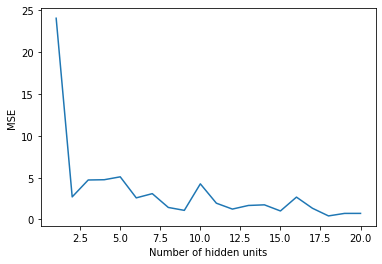

MSE on the original scale: 0.10230222678905838


In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataframe
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')
df = df.drop(columns=['Date'])

# Normalize the predictor variables
scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:, :-2])

# Define the target variable and perform normalization
y = df.iloc[:, -2:-1].values
y = y.ravel()  # Add this line to avoid DataConversionWarning
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Define the model and parameter grid for grid search
model = MLPRegressor(activation='relu', solver='adam', max_iter=1000)
param_grid = {'hidden_layer_sizes': np.arange(1, 21)}

# Perform grid search with 10-fold cross validation
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=10))
grid_search.fit(X, y)

# Print the best parameters and MSE
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# Plot the MSE as a function of the number of hidden units
results = grid_search.cv_results_
plt.plot(results['param_hidden_layer_sizes'].data, -results['mean_test_score'])
plt.xlabel('Number of hidden units')
plt.ylabel('MSE')
plt.show()

# Transform the predicted values back to the original scale
y_pred = grid_search.predict(X)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Calculate the MSE on the original scale
mse = mean_squared_error(y_true, y_pred)
print("MSE on the original scale:", mse)


### MLP: Visualizing the training epoch

100%|██████████| 59/59 [00:14<00:00,  3.99it/s]


Best parameters: {'hidden_layer_sizes': 48}
Best MSE: 0.27987998392376057


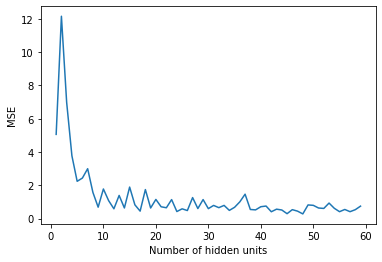

MSE on the original scale: 0.0928700078471783


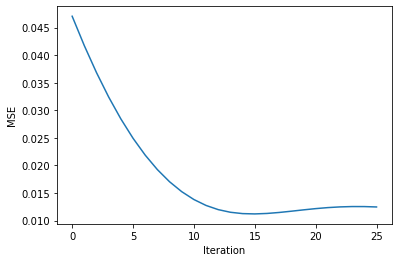

In [71]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning

import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

# Load the dataframe
df = pd.read_csv('./data/processed_sa_bert_price_diff.csv')
df = df.drop(columns=['Date'])

# Normalize the predictor variables
scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:, :-2])

# Define the target variable and perform normalization
y = df.iloc[:, -2:-1].values
y = y.ravel()
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Define the model and parameter grid for grid search
model = MLPRegressor(activation='relu', solver='adam', max_iter=1000)
param_grid = {'hidden_layer_sizes': np.arange(1, 60)}

# Perform grid search with 10-fold cross validation
scores = []
for param in tqdm(param_grid['hidden_layer_sizes']):
    model.set_params(**{'hidden_layer_sizes': param})
    with warnings.catch_warnings():  
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        cv_scores = -1 * cross_val_score(model, X, y, cv=KFold(n_splits=10))
        scores.append(np.mean(cv_scores))

best_score_idx = np.argmin(scores)
best_score = scores[best_score_idx]
best_params = {'hidden_layer_sizes': param_grid['hidden_layer_sizes'][best_score_idx]}

# Print the best parameters and MSE
print("Best parameters:", best_params)
print("Best MSE:", best_score)

# Plot the MSE as a function of the number of hidden units
plt.plot(param_grid['hidden_layer_sizes'], scores)
plt.xlabel('Number of hidden units')
plt.ylabel('MSE')
plt.show()

# Fit the model with the best parameters
model.set_params(**best_params)
model.fit(X, y)

# Transform the predicted values back to the original scale
y_pred = model.predict(X)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Calculate the MSE on the original scale
mse = mean_squared_error(y_true, y_pred)
print("MSE on the original scale:", mse)

# Visualize the training procedure
plt.plot(model.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()
